In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import logging

import ipyvolume as ipv
import ipywidgets as widgets

from ipywidgets import FloatProgress
from IPython.display import display, Image

from tyssue import HistoryHdf5
from tyssue.solvers import QSSolver


from tyssue.draw import sheet_view, browse_history
from tyssue.io import hdf5
from tyssue.draw import highlight_faces, create_gif, highlight_cells


from pathlib import Path

from utils import (
    WAMonolayerGeometry as geom,
    MonolayerView,
    get_initial_follicle,
    get_solver,
    get_polar_cells,
    update_gradient
)

rcParams["figure.figsize"] = (9, 6)
rcParams["figure.dpi"] = 96

from collections import deque

class LogWidget(widgets.HTML):
    
    def __init__(self, maxlines=10):
        
        self.lines = deque(maxlen=maxlines)
        super().__init__()
    
    def write(self, record):
        self.lines.append(record)
        self.value = '\n'.join(
            [f"<p>{rec}</p>" for rec in self.lines])
    def flush(self):
        pass

        
logger = logging.getLogger("tyssue")
logger.setLevel("DEBUG") # INFO ERROR WARNING

handled = False
if not handled:
    hand = logging.FileHandler("follicle.log")
    hand.setLevel("INFO")
    logger.addHandler(hand)
    handled = True
        
        


## Follicle monolayer creation


## Base mechanical model


By analogy with 2D Manning model (by a suggestion she did during a communication, I assume this will be published some time) we can write the basic potiential with

$$
E = \frac{K_\ell}{2}(V_\ell - V_\ell^0)^2 + \sum_c \frac{K_v}{2}(V_c - V_c^0)^2 + \frac{K_A}{2}(A_c - A_c^0)^2
$$

By setting $V_c^0 = 1$ and $K_c^0 = 1$, we rewrite this:

$$
E = \frac{K_\ell}{2}(V_\ell - V_\ell^0)^2 + \sum_c \frac{1}{2}(V_c - 1)^2 + \frac{K_A}{2}(A_c - s^0)^2
$$

Here $s^0$ is the form factor (as in 2D)

For a sphere, the ratio $A / V^{2/3}$ is equal to $(36\pi)^{1/3} \approx 4.84$

For a [truncated octahedron](https://en.wikipedia.org/wiki/Truncated_octahedron) (regular cells in bulk), it's 5.31 and 8.14 for a honeycomb (cuboidal cells).

## Cell area as a weighted sum of face areas


For now the model is isotropic, so cells will tend to adopt the most spherical shape possible. In order to have polarisation, we can introduce a factor (or weight) on each face of the cell to modulate its effective contribution to the total area, the total area $A_c$ is replaced by the weighted area $A'_c$:

$$
A_c = \sum_f A_f \quad \mbox{becomes}\\
A'_c = \frac{n_f}{\sum_f w_f}\sum_f w_fA_f
$$

If all the weights are equal, the weighted area is equal to the normal area.



### Settings for the mechanical model

In [6]:
# Number of cells
Nc = 200

specs = {
    "cell": {
        "is_alive": 1,
        "vol_elasticity": 1.0,
        "prefered_vol": 1.0,
        "weighted_area": 1.0,
        "area_elasticity": 0.1, # this has to be explored
        "prefered_area": 4.6,  # form factor - this has to be explored
        # bigger prefered_area -> more fluid tissue
    },
    "face": {
        "weight": 1.0,
        "is_alive": 1,
    },
    "settings": {
        "lumen_vol_elasticity": 1.0e-3, # this has to be explored
        "lumen_prefered_vol": 300, # this has to be explored
        "apical_weight": 1.0,
    },
}


In [7]:
follicle, model = get_initial_follicle(specs)
print(f"Follicle has {follicle.Nc} cells")
print(follicle.settings)

Finding static equilibrium
Follicle has 216 cells
{'lumen_side': 'apical', 'lumen_vol': 280.90998584239736, 'lumen_vol_elasticity': 0.001, 'lumen_prefered_vol': 300, 'apical_weight': 1.0}


In [8]:
follicle.face_df.head() # pandas DataFrame

,x,y,z,num_sides,area,perimeter,is_alive,segment,visible,id,face_o,opposite,height,rho,vol,phi,theta,weight,cell
face,,,,,,,,,,,,,,,,,,,
0,-2.308287,3.310672,-0.431535,6,1.031444,3.812096,1,apical,True,0,0,-1,4.999044,8.999044,28.741082,2.191955,-0.10952,1.0,0
1,-2.144640,3.393149,0.545859,6,0.952748,3.689579,1,apical,True,0,0,-1,4.999044,8.999044,28.741082,2.191955,-0.10952,1.0,1
2,-1.428630,3.807074,-0.114398,6,1.018820,3.779824,1,apical,True,0,0,-1,4.999044,8.999044,28.741082,2.191955,-0.10952,1.0,2
3,3.842852,-1.154075,-0.296746,5,0.948743,3.761042,1,apical,True,0,0,-1,4.999044,8.999044,28.741082,2.191955,-0.10952,1.0,3
4,3.506111,-1.762462,-0.948054,6,0.917564,3.647107,1,apical,True,0,0,-1,4.999044,8.999044,28.741082,2.191955,-0.10952,1.0,4


In [9]:
follicle.cell_df.head() # pandas DataFrame

,x,y,z,is_alive,area,vol,num_faces,id,num_ridges,vol_elasticity,prefered_vol,area_elasticity,prefered_area,weighted_area
cell,,,,,,,,,,,,,,
0,-2.492838,3.586443,-0.470121,1,5.155824,0.797746,8,0,36,1.0,1.0,0.1,4.6,5.155824
1,-2.336958,3.677415,0.626215,1,5.142151,0.799392,8,1,36,1.0,1.0,0.1,4.6,5.142151
2,-1.554658,4.119677,-0.108503,1,5.151117,0.799196,8,2,36,1.0,1.0,0.1,4.6,5.151117
3,4.176763,-1.264469,-0.319900,1,5.121339,0.783358,7,3,30,1.0,1.0,0.1,4.6,5.121339
4,3.827693,-1.904068,-1.037800,1,5.134322,0.799779,8,4,36,1.0,1.0,0.1,4.6,5.134322


In [ ]:
follicle.cell_df.loc[follicle.cell_df["z"]>0, "vol_elasticty"] = 2.0

In [15]:
follicle.face_df.loc[follicle.lateral_faces, "x"]

face
432    -2.029808
433    -3.176828
434     2.448445
435    -2.541315
436     2.573332
          ...   
1711   -4.114660
1712   -3.100590
1713   -3.936890
1714    0.238389
1715   -0.188989
Name: x, Length: 1284, dtype: float64

In [18]:
follicle.edge_df[["srce", "trgt", "face", "cell"]].head()

,srce,trgt,face,cell
edge,,,,
0,172,171,0,0
1,208,318,143,143
2,3,147,71,71
3,412,411,144,144
4,13,3,71,71


In [23]:
face = 1336
follicle.edge_df.loc[follicle.edge_df["face"]==face, 'cell']

edge
6184    10
6185    10
6186    10
6187    10
Name: cell, dtype: int64

#### 3D vizualisation

In [24]:
draw_specs = {
    'edge': {
        'visible': False,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['area']
    },
}

ipv.clear()

# filter visible cells

follicle.face_df['visible'] = (
    (follicle.face_df['y'] > 0)
    | (follicle.face_df['x'] > 0)
)

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

## Contractility gradient

The contractility gradient is modeled as an increase in the cells apical face _weight_

In [26]:
polar_cells = get_polar_cells(follicle)
update_gradient(follicle, polar_cells, amp=6, span=3) # amp and span are critical parameters

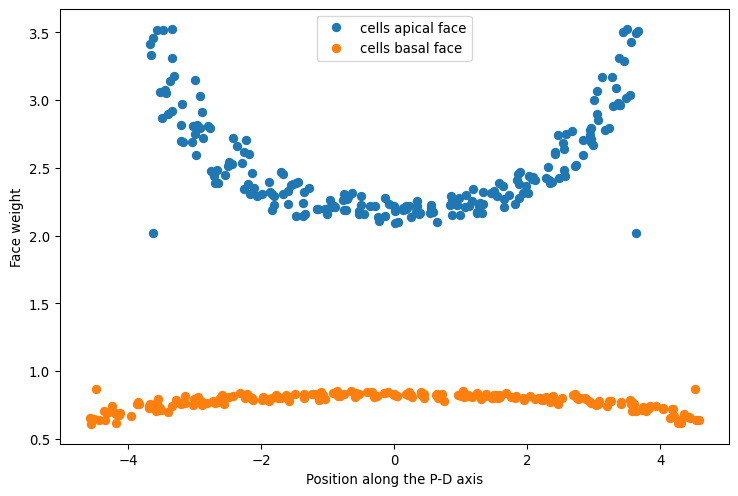

In [36]:

fig, ax = plt.subplots()
ax.plot(
    follicle.face_df.loc[follicle.apical_faces, "z"],
    follicle.face_df.loc[follicle.apical_faces, "weight"],
    'o',
    label="cells apical face"
)
ax.plot(
    follicle.face_df.loc[follicle.basal_faces, "z"],
    follicle.face_df.loc[follicle.basal_faces, "weight"],
    'o',
    label="cells basal face"
)

ax.set_xlabel("Position along the P-D axis")
ax.set_ylabel("Face weight")
l = ax.legend()


In [29]:

ipv.clear()
follicle.face_df['visible'] = True
follicle.face_df.loc[follicle.basal_faces, 'visible'] = False

draw_specs = {
    'edge': {
        'visible': False,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['weight']
    },
}

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

### Initial quasistatic equilibrium with the chosen gradient parameters

In [53]:
quasistatic_solve = True

if quasistatic_solve:
    solver = QSSolver()
    res = solver.find_energy_min(follicle, geom, model)
    print(res.message)


CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


In [49]:
ante, post = get_polar_cells(follicle)


In [50]:
from tyssue.topology.monolayer_topology import cell_division

In [51]:
cell_division(follicle, ante, orientation="apical")
cell_division(follicle, post, orientation="apical")


217

In [54]:
draw_specs = {
    'edge': {
        'visible': False,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['area']
    },
}

follicle.face_df['visible'] = (
    (follicle.face_df['y'] > 0)
    | (follicle.face_df['x'] > 0)
)
ipv.clear()
fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

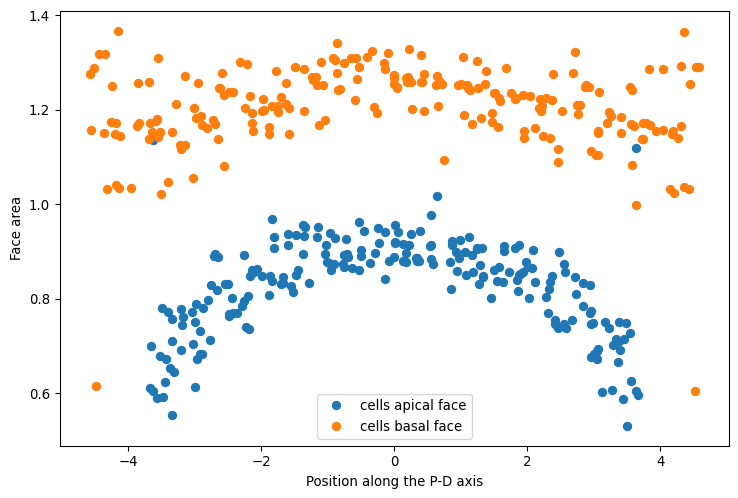

In [37]:
fig, ax = plt.subplots()
ax.plot(
    follicle.face_df.loc[follicle.apical_faces, "z"],
    follicle.face_df.loc[follicle.apical_faces, "area"],
    'o',
    label="cells apical face"
)
ax.plot(
    follicle.face_df.loc[follicle.basal_faces, "z"],
    follicle.face_df.loc[follicle.basal_faces, "area"],
    'o',
    label="cells basal face"
)

ax.set_xlabel("Position along the P-D axis")
ax.set_ylabel("Face area")
l = ax.legend()

### More detailed viewer

In [46]:
follicle.face_df['visible'] = follicle.face_df['segment'] == "apical"
MonolayerView(follicle, **draw_specs)

MonolayerView(children=(Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), projectionMatrix=(…

## Cell division and dynamic model

$$
\ln(V_\mathrm{lum})(t) = a + k_V t\\
V_\mathrm{lum}(t) = V_0 e^{k_V t}
$$



In [41]:
follicle.update_specs(
    {'settings':
     {
        # Critical length to trigger rearangements
        "threshold_length": 1e-2,
        # Frequency of rearangements
        "p_4": 0.1,
        "p_5+": 0.01,
    },
    'vert': {
        "viscosity": 0.1
    },
})

follicle.cell_df["id"] = follicle.cell_df.index
polar_cells_ids = tuple(follicle.cell_df.loc[list(polar_cells), "id"])

parameters = {
    "amp": 6,
    "span": 3,
    "growth_rate": 0.01,
    "growth_noise": 0.01,
    "orientation": "apical", # or "vertical"
    "critical_vol": 1.4,
    "autonomous": True,
    "polar_cells_ids": polar_cells_ids,
    "lumen_growth_rate": 0.014
}
    
base_dir = Path("../data")
time_stamp = datetime.today().strftime("%y-%m-%d-%H-%M-%S")
history_file = Path(f"hist2D_{time_stamp}.hf5")

# We take the time unit as 1/100th of a development stage
dt = 1e-2
time_span = 3

progress = FloatProgress(min=0, max=time_span)
solver = get_solver(
    follicle,
    model,
    dt,
    base_dir,
    history_file,
    parameters,
    save_interval=dt*10)
    
def update_progress(mono, manager):
    progress.value = manager.clock * dt
    manager.append(update_progress)
    
solver.manager.append(update_progress)

The created solver resolves the system of first order differential equations:

$$\eta v = \sum F $$

Where the forces are computed as the opposite of the gradients from the model


In [47]:
log_widget = LogWidget()
handler = logging.StreamHandler(log_widget)
handler.setLevel("INFO")
logger.addHandler(handler)


widgets.VBox([progress, log_widget])

In [48]:
solver.solve(time_span, dt)

In [45]:
draw_specs["edge"]["visible"] = True


browse_history(solver.history, **draw_specs)


interactive(children=(IntSlider(value=0, description='i', max=14), Output()), _dom_classes=('widget-interact',…

## Demo of cell division oriented by apical vertices

In [ ]:
qssolver = QSSolver()
res = qssolver.find_energy_min(solver.eptm, geom, model)

In [ ]:
from tyssue.utils import single_cell
from tyssue import MonolayerGeometry as mgeom
from tyssue.topology.monolayer_topology import cell_division

scell = single_cell(follicle, 9, copy=True)

mgeom.center(scell)
mgeom.update_all(scell)

apical_verts = scell.vert_df.loc[scell.vert_df["segment"]=="apical"]

u, s, vh = np.linalg.svd(apical_verts[scell.coords])

cell_division(scell, 0, orientation="apical")

ipv.clear()
fig, mesh = sheet_view(scell, mode="3D")
colors = ["red", "green", "blue"]
lines = [
    ipv.plot(
        x=[0, s[i]*vh[i, 0]],
        y=[0, s[i]*vh[i, 1]],
        z=[0, s[i]*vh[i, 2]],
        color=colors[i]
    )
    for i in range(3)
]
fig